In [70]:
#import modules
import loaddata
import pandas as pd
%matplotlib inline
import sys
import os
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import statsmodels.formula.api as smf
import patsy
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import RidgeCV
from IPython.core.pylabtools import figsize

In [71]:
# load the data
movie_dicts = loaddata.load_mojo_data()
movie_df = pd.DataFrame(movie_dicts)

meta_dicts = loaddata.load_metacritic_data()
meta_df = pd.DataFrame(meta_dicts)

# merge the data 
movie_df['title_strip']=movie_df['title'].str.strip()
meta_df['title_strip']=meta_df['title'].str.strip()

movie_inner=movie_df.merge(meta_df,on='title_strip', how='inner')


Parsed 3728 movies from 3728 files
Parsed 4765 metacritic files from 4767 files


In [72]:
# create top 3 director indicators (by worldwide gross)
movie_inner['top_dir']=movie_inner['director_y'].apply(lambda x: 1 if x.find('Lee Unkrich')>=0 or x.find('James Cameron')>=0 
                                                       or x.find('Shane Black') or x.find('George Lucas') >= 0 else 0)


In [73]:
# create season column based on release date (summer, holiday, other)
movie_inner['summer']=movie_inner['release_date'].apply(lambda x: 1 if ('05' <= x[5:7] <= '08') 
                                                        else 0)

movie_inner['holiday']=movie_inner['release_date'].apply(lambda x: 1 if ('11' <= x[5:7] <= '12')
                                                        else 0)

movie_inner['other_seas']=movie_inner['release_date'].apply(lambda x: 1 if ('01' <= x[5:7] <= '04') or ('09' <= x[5:7] <= '10') else 0)

In [74]:
# create genre columns
movie_inner['act_adv_thril']=movie_inner['genre'].apply(lambda x: 1 if (x.find('Action')>=0 or x.find('Adventure')>=0 or x.find('Thriller')>=0) else 0)
movie_inner['other_gen']=movie_inner['genre'].apply(lambda x: 1 if (x.find('Fantasy')<0 and x.find('Horror')<0 and x.find('Sci-Fi')<0
                                                                   and x.find('Romance')<0 and x.find('Drama')<0 and x.find('Action')<0
                                                                   and x.find('Adventure')<0 and x.find('Thriller')<0 and x.find('Comedy')<0) else 0)

In [113]:
# create rating indicator col
movie_inner['pg13']=movie_inner['rating'].apply(lambda x: 1 if (x.find('PG-13')>=0 or x.find('PG--13')>=0) else 0)
movie_inner['r']=movie_inner['rating'].apply(lambda x: 1 if (x.find('R')>=0) else 0)
movie_inner['g']=movie_inner['rating'].apply(lambda x: 1 if (x.find('G')==0) else 0)

In [102]:
# create ln production budget
movie_inner['ln_prod_budget']=np.log(movie_inner['production_budget'])

In [118]:
# define features
features=['summer','r','g','act_adv_thril','runtime_minutes','year_x','production_budget']
related_columns = features + ['domestic_gross']

In [119]:
#clean the data
clean_movie = movie_inner[related_columns].dropna()
print '%i movies with all necessary info.' % len(clean_movie)

1436 movies with all necessary info.


In [120]:
# build a model
import statsmodels.api as sma
Y = clean_movie['domestic_gross']
X = sma.add_constant(clean_movie[features])
dm_gross_model = sma.OLS(Y, X).fit()
dm_gross_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     99.19
Date:                Thu, 30 Jun 2016   Prob (F-statistic):          3.45e-118
Time:                        17:30:38   Log-Likelihood:                -27636.
No. Observations:                1436   AIC:                         5.529e+04
Df Residuals:                    1428   BIC:                         5.533e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const              3.183e+09   4.43e+08      7.191      0.000      2.31e+09  4.05e+09
summer             1.578e+07   3.21e+06      4.917      0.000      9.49e+06  2.21e+07
r                 -1.322e+07   3.15e+06     -4.192      0.000     -1.94e+07 -7.03e+06
g                  3.686e+07   1.02e+07      3.620      0.000      1.69e+07  5.68e+07
act_adv_thril     -5.762e+06   3.15e+06     -1.827      0.068     -1.19e+07  4.26e+05
runtime_minutes    2.526e+05   7.72e+04      3.271      0.001      1.01e+05  4.04e+05
year_x            -1.586e+06    2.2e+05     -7.206      0.000     -2.02e+06 -1.15e+06
production_budget     0.7774      0.043     18.195      0.000         0.694     0.861
==============================================================================
Omnibus:                      693.938   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5580.716
Skew:                           2.091   Prob(JB):                         0.00
Kurtosis:                      11.706   Cond. No.                     1.86e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.86e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

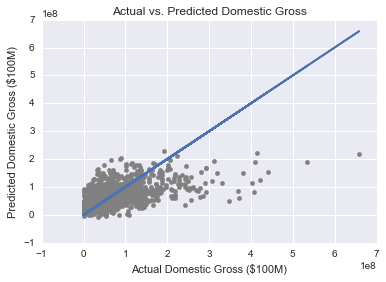

In [121]:
predicted_gross = dm_gross_model.predict(X)
plt.scatter(clean_movie.domestic_gross, predicted_gross, color='gray')
plt.plot(clean_movie.domestic_gross, clean_movie.domestic_gross)
plt.title("Actual vs. Predicted Domestic Gross")
plt.xlabel("Actual Domestic Gross ($100M)")
plt.ylabel("Predicted Domestic Gross ($100M)")

In [ ]:
def model_eq(summer_ind,holiday_ind,opening_weekend_take,pg13_und_ind,drama_romance_ind,
             act_adv_thril_ind,comedy_ind,fant_hor_sci_ind,other_gen_ind,metascore):
    """
    returns predicted worldwide gross based on indicators
    summer_ind: is movie released in may-aug (1,0)
    holiday_ind: is movie released in nov-dec (1,0)
    opening_weekend_take: estimate (or actual) opening weekend take (millions)
    pg13_und_ind: is the movie rated pg13 or under? (1,0)
    drama_romance_ind: is the movie genre drama or romance? (1,0)
    act_adv_thril_ind: is the movie genre action, adventure, or romance? (1,0)
    comedy_ind: is the movie genre comedy? (1,0)
    fant_hor_sci_ind: is the movie genre fantasy, horror, or sci-fi? (1,0)
    metascore: actual or predicted metacritic score
    """
    pred_ww_gross=-9.27e+07+1.956e+07*summer_ind+4.353e+07*holiday_ind+7.2976*opening_weekend_take+2.169e+07*pg13_und_ind-1.945e+06*drama_romance_ind+1.757e+07*act_adv_thril_ind+3.626e+06*comedy_ind-4.762e+05*fant_hor_sci_ind-2.342e+07*other_gen_ind+1.303e+06*metascore
    return pred_ww_gross